# llc4320 drifters spectra

Computes periodograms over rolling windows

In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datawork/aponte/miniconda3/envs/equinox/share/proj failed
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    cluster = PBSCluster(cores=14, processes=7)
    w = cluster.scale(jobs=8)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
cluster

Dashboard: http://10.148.0.38:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.38:56483,Workers: 0
Dashboard: http://10.148.0.38:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---
## load data

In [ ]:
#root_dir = '/home1/datawork/aponte/parcels/'
#root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
root_dir = os.path.join(ut.root_data_dir, 'parcels')
#run_name = 'global_extra_T365j_dt1j_dij50'
run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(os.path.join(root_dir, run_name), 
                      parquets=['trajectory', 'trajectory_mean'],
                      #parquet_kwargs=dict(engine="pyarrow"),
                     )
df = p['trajectory_mean']

In [5]:
# add time in hours
df = df.rename(columns={'time': 'date'})

# filter out bad data (there are some with negative trajectory and NaN)
df = df.dropna()

time_unit = pd.Timedelta('1h')
t_start = df.date.min().compute()
t_end = df.date.max().compute()
df['time'] = (df['date'] - t_start)/time_unit # safer to work with time in seconds

# Should check time sampling more thoroughly at some points
# we know there are many duplicates, 
# some may have similar dates/trajectory but different data

df = df.persist()
# 58GB on disk, 75GB in memory

df.head()

,date,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,waterdepth,mean_sea_level,mean_zonal_velocity,mean_meridional_velocity,time
trajectory,,,,,,,,,,,,
39000000,2011-11-15 00:00:00,57.853661,-178.856766,0.0,0.000000,0.000000,0.000000,0.000000,0.060621,-0.005961,-0.004107,0.0
39000000,2011-11-15 01:00:00,57.845396,-178.861217,0.0,-0.155088,-0.249927,0.921884,3749.076904,0.060847,-0.004133,-0.005197,1.0
39000000,2011-11-15 02:00:00,57.838902,-178.874172,0.0,-0.272537,-0.153622,0.987710,3749.076904,0.060951,-0.002708,-0.005794,2.0
39000000,2011-11-15 03:00:00,57.835855,-178.893247,0.0,-0.360190,-0.020691,0.826575,3749.076904,0.060624,-0.001933,-0.004686,3.0
39000000,2011-11-15 04:00:00,57.836742,-178.913583,0.0,-0.310784,0.091132,0.475389,3683.949951,0.060441,-0.001279,-0.004085,4.0


In [6]:
def print_info(df):
    partition_size = df.memory_usage_per_partition().compute().loc[0]
    print("Partition size = {:.0f} MB".format(partition_size/1e6))

    df_size = df.memory_usage().compute().sum()
    print("Dataset global size = {:.0f} GB".format(df_size/1e9))

    num_drifters = len(df.index.unique().compute())
    print("Total number of drifters (trajectory) = {:d}".format(num_drifters))
    return num_drifters

num_drifters = print_info(df)

Partition size = 99 MB
Dataset global size = 59 GB
Total number of drifters (trajectory) = 99472


In [7]:
num_drifters_original = print_info(p['trajectory'].dropna())

Partition size = 99 MB
Dataset global size = 43 GB
Total number of drifters (trajectory) = 99760


In [8]:
# bad data point: negative trajectory id and NaN values for all variables
# are there other for 'time' data?
if False:
    _df = df.reset_index()
    _df = _df[_df.trajectory<0].compute()
    print(_df.index.size)
    _df.head()

---

## start processing

In [9]:
def process_uv(lon, lat, u, v, N, dt, **kwargs):
    ''' Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        u, v: pd.Series
            zonal, meridional index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    if lon is None:
        uv = None
    else:
        uv = u + 1j*v
    return dr.get_spectrum(uv, N, dt=dt, **kwargs)

def process_lonlat(lon, lat, N, dt, **kwargs):
    ''' Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        lon,lat: pd.Series
            Longitude index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    if lon is None:
        uv = None
    else:
        # compute displacements
        lon1, lat1 = lon.shift(periods=-1), lat.shift(periods=-1)
        u = dr.haversine(lon, lat, lon1, lat)*1e3 *np.sign(lon1-lon) /dt/86400
        v = dr.haversine(lon, lat, lon, lat1)*1e3 *np.sign(lat1-lat) /dt/86400
        u = pd.Series(u, index=lon.index).fillna(method='ffill')
        v = pd.Series(v, index=lon.index).fillna(method='ffill')
        uv = u + 1j*v
    return dr.get_spectrum(uv, N, dt=dt, **kwargs)

def process_real(v, N, dt, **kwargs):
    ''' Wraps spectral calculation of a real variable (e.g. temperature, ...)
    Assumes the time series is regularly sampled
    
    Parameters:
    -----------
        lon,lat: pd.Series
            Longitude index by time (in days)
        N: int,
            length of the spectrum
        dt: float
            Time sampling in days
        **kwargs:
            passed to mit_equinox.drifters.get_spectrum
    '''
    _kwargs = dict(return_onesided=True)
    _kwargs.update(kwargs)
    #N = int(N/2)+1
    return dr.get_spectrum(v, N, dt=dt, **_kwargs)

## velocity

**Cell below is the computationnally intensive part**

Peaks at 220GB of RAM

In [14]:
mean = 2 # 0=raw time series, 1=raw-mean, 2=mean

#T_str = '30D' # days
T_str = '60D' # days
#T_str = '90D' # days
dt = '1h' # sampling

N = int(pd.Timedelta(T_str)/pd.Timedelta(dt)) # output size
T = pd.Timedelta(T_str)/time_unit # must be in the same units than time

columns = ['lon', 'lat']
if mean==0:
    columns = columns + ['zonal_velocity', 'meridional_velocity']    
elif mean==1:
    df["zonal_velocity_prime"] = df["zonal_velocity"] - df["mean_zonal_velocity"]
    df["meridional_velocity_prime"] = df["meridional_velocity"] - df["mean_meridional_velocity"]
    columns = columns + ['zonal_velocity_prime', 'meridional_velocity_prime']
elif mean==2:
    columns = columns + ['mean_zonal_velocity', 'mean_meridional_velocity']

df_chunked = (df
              .groupby("trajectory")
              .apply(dr.time_window_processing,
                     process_uv,
                     columns,
                     T,
                     N,
                     id_label='trajectory',
                     dt=dt,
                    )
              .persist()
             )

# lon/lat processing
#df_chunked = (df
#              .groupby(df.index)
#              .apply(dr.time_window_processing,
#                     process_lonlat,
#                     ['lon', 'lat'],
#                     T, 
#                     N,
#                     id_label='trajectory',
#                     dt=dt,
#                    )
#              .persist()
#             )

#note: grouping on index has not allways been working, 
# may need to reset_index and group on column

# new 
df_chunked.index.rename("time", inplace=True)

# old
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
#df_chunked = (
#              df_chunked.map_partitions(
#                  lambda df: df.index.rename("time", inplace=True)
#                              #df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
#                                       )
#              )
#df_chunked = df_chunked.drop(columns='id')

df_chunked.head()

/dev/shm/pbs.9664352.datarmor0/ipykernel_12611/421829383.py:21: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df
/home1/datawork/aponte/miniconda3/envs/equinox/lib/python3.10/site-packages/dask/dataframe/core.py:4099: FutureWarning: 'inplace' argument for dask series will be removed in future versions
  warnings.warn(


lon        lat         id       0.0   0.016667  \
trajectory                                                                
2000589    720.0  -12.865115 -65.231817  2000589.0  0.012276   0.000686   
           1440.0 -13.927717 -64.609446  2000589.0  0.016042   0.003782   
           2160.0 -13.698827 -64.147253  2000589.0  0.032173   0.009829   
           2880.0 -13.422408 -63.777003  2000589.0  0.036596   0.007151   
           3600.0 -13.500080 -63.351518  2000589.0  0.034232   0.006456   

                    0.033333      0.05      0.066667   0.083333       0.1  \
trajectory                                                                  
2000589    720.0    0.000182  0.000175  2.019443e-04   0.000025  0.000001   
           1440.0   0.000163  0.000011  5.792578e-06   0.000006  0.000010   
           2160.0   0.000018  0.000002  1.770818e-07   0.000003  0.000004   
           2880.0   0.000043  0.000005  4.326568e-06   0.000005  0.000003   
           3600.0   0.000723  0.000097  1.343631e-05   0.000043  0.000017   

                   ...     -0.166667         -0.15  -0.133333  -0.116667  \
trajectory         ...                                                     
2000589    720.0   ...  9.831731e-06  3.950174e-06   0.000006   0.000004   
           1440.0  ...  4.000379e-07  9.615746e-07   0.000003   0.000005   
           2160.0  ...  6.856906e-06  4.877695e-06   0.000004   0.000003   
           2880.0  ...  2.314950e-06  3.018039e-06   0.000006   0.000019   
           3600.0  ...  3.237216e-06  2.585959e-06   0.000008   0.000007   

                       -0.1  -0.083333  -0.066667     -0.05  -0.033333  \
trajectory                                                               
2000589    720.0   0.000012   0.000019   0.000008  0.000011   0.000120   
           1440.0  0.000002   0.000003   0.000006  0.000007   0.000050   
           2160.0  0.000007   0.000006   0.000005  0.000006   0.000006   
           2880.0  0.000026   0.000032   0.000065  0.000169   0.000388   
           3600.0  0.000015   0.000023   0.000034  0.000023   0.000254   

                   -0.016667  
trajectory                    
2000589    720.0    0.007813  
           1440.0   0.004285  
           2160.0   0.007477  
           2880.0   0.012869  
           3600.0   0.014372  

[5 rows x 1443 columns]

In [15]:
# store to parquet
parquet = 'spectra_raw_uv_T{}_mean{}'.format(int(T_str[:-1]), mean)

df_chunked.columns = df_chunked.columns.astype(str) # fastparquet does not allow float column names
p.store_diagnostic(parquet, df_chunked, overwrite=True)

No reindexing
create new archive: /home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics/spectra_raw_uv_T60_mean2


## tracers

In [8]:
v = 'temperature'
#v = 'salinity'
#v = 'sea level'

In [9]:
T = '60D' # days
dt = '1H' # sampling

N = int(pd.Timedelta(T)/pd.Timedelta(dt)) # output size
T = pd.Timedelta(T)/time_unit # must be in the same units that time

df_chunked = (df
              .groupby(df.index)
              .apply(dr.time_window_processing,
                     process_real,
                     ['temperature'],
                     T, 
                     N,
                     id_label='trajectory',
                     dt=dt,
                    )
              .persist()
             )

#note: grouping on index has not allways been working, 
# may need to reset_index and group on column

# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
df_chunked = df_chunked.drop(columns='id')
df_chunked.head()

<ipython-input-9-34f47b809e2b>:7: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df


,time,lon,lat,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,11.85,11.866666666666667,11.883333333333333,11.9,11.916666666666666,11.933333333333334,11.95,11.966666666666667,11.983333333333333,12.0
trajectory,,,,,,,,,,,,,,,,,,,,,
1000207,120.0,-26.770351,-75.351169,137.903870,69.322136,0.001280,0.000196,0.001208,0.000353,0.000326,...,5.996031e-08,4.706557e-08,3.223492e-08,4.436894e-08,6.057635e-08,1.644082e-09,4.761263e-08,3.025492e-08,5.703403e-08,1.149781e-10
1000207,150.0,-29.163544,-76.060546,139.656174,69.882080,0.000009,0.000044,0.000006,0.000006,0.000012,...,1.939989e-09,7.530394e-10,3.966165e-10,3.778581e-10,1.407654e-09,9.570944e-10,1.940154e-09,6.307867e-10,9.252107e-10,1.408482e-11
1000207,180.0,-32.524974,-76.693448,139.952423,69.859123,0.000092,0.000073,0.000067,0.000045,0.000032,...,7.228029e-09,1.289028e-08,1.738962e-08,1.390623e-08,1.360081e-08,9.292967e-09,5.717919e-09,1.147936e-08,7.722355e-09,1.932782e-09
1000207,210.0,-36.271188,-77.390706,141.131058,70.694962,0.000139,0.000049,0.000014,0.000015,0.000016,...,2.185479e-08,4.135648e-09,3.900247e-09,8.802009e-10,7.272233e-09,1.485804e-09,1.739498e-09,9.323539e-09,7.913636e-09,2.760624e-09
1000207,240.0,-39.300011,-77.743990,141.318054,70.638672,0.000011,0.000003,0.000005,0.000003,0.000003,...,1.353111e-10,3.874479e-10,2.696638e-09,6.601137e-11,8.830375e-10,2.131494e-10,1.364898e-09,1.423898e-09,1.730927e-09,7.772520e-10


In [10]:
# store to parquet
df_chunked.columns = df_chunked.columns.astype(str) # fastparquet does not allow float column names
p.store_diagnostic('spectra_raw_'+v.replace(" ","-"), df_chunked, overwrite=True)

No reindexing
deleting existing archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_raw_temperature
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics/spectra_raw_temperature


--- 

## inspect result

**Could move to another notebook from here**

In [36]:
# read parquet file
parquet = 'spectra_raw_uv_T{}_mean{}'.format(int(T_str[:-1]), mean)
df_chunked = p.load_diagnostic(parquet)

df_chunked = df_chunked.persist()
df_chunked.head()

,lon,lat,id,0.0,0.016666666666666666,0.03333333333333333,0.05,0.06666666666666667,0.08333333333333333,0.1,...,-0.16666666666666666,-0.15,-0.13333333333333333,-0.11666666666666667,-0.1,-0.08333333333333333,-0.06666666666666667,-0.05,-0.03333333333333333,-0.016666666666666666
720,-24.355661,-68.682725,2000332.0,0.027890,0.005901,0.000037,0.000070,0.000034,7.518072e-06,0.000007,...,0.000002,1.004745e-06,0.000005,0.000004,0.000012,1.513537e-05,0.000001,0.000024,0.000008,0.008634
1440,-26.630897,-68.386643,2000332.0,0.020213,0.003644,0.000085,0.000011,0.000002,4.761133e-07,0.000006,...,0.000002,7.448109e-07,0.000002,0.000008,0.000006,4.612475e-07,0.000014,0.000018,0.000067,0.006919
2160,-28.531372,-68.346101,2000332.0,0.020249,0.006675,0.000068,0.000020,0.000023,8.414177e-06,0.000002,...,0.000005,1.241106e-06,0.000011,0.000014,0.000004,9.618347e-06,0.000032,0.000026,0.000077,0.004376
2880,-30.639630,-68.123406,2000332.0,0.011798,0.002796,0.000071,0.000010,0.000150,8.772473e-05,0.000042,...,0.000011,6.887895e-07,0.000004,0.000010,0.000029,5.311378e-05,0.000219,0.000237,0.000001,0.002728
3600,-33.159836,-67.553017,2000332.0,0.017335,0.003755,0.000027,0.000037,0.000016,4.261998e-06,0.000003,...,0.000003,8.149378e-06,0.000002,0.000009,0.000012,1.535489e-05,0.000018,0.000042,0.000023,0.005801


7920


<AxesSubplot: >

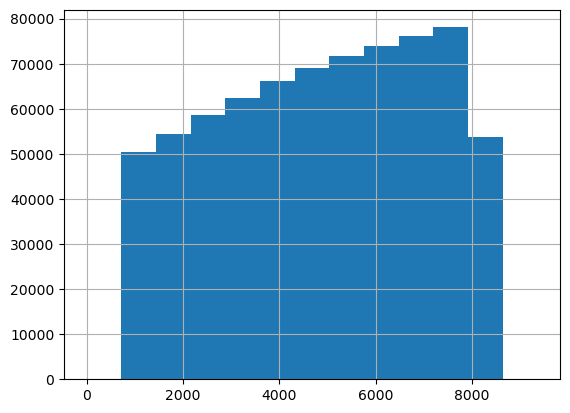

In [40]:
t = df_chunked.reset_index()['index'].compute()
print(t.max())
t.hist(bins=np.arange(0,400*24,30*24))

In [43]:
# bin geographically
lat_bins = np.arange(-60, 60, 1.)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df_chunked.groupby(['lat_cut']).mean().compute()

#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
              .drop(columns=['lon','lat'])
              .reset_index(), id_vars=['lat_cut',], var_name='frequency')
              .rename(columns={'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
ds['frequency'] = ds['frequency'].astype(float)
ds = ds.sortby('frequency')

# store diagnostic (not done here)
#p.store_diagnostic('spectra_lat', ds, overwrite=True)

# may be loaded with 
#ds = p.load_diagnostic('spectra_lat.zarr')

ValueError: could not convert string to float: 'id'

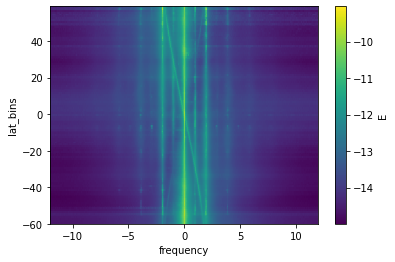

In [39]:
np.log10(ds.E).plot()

## Close cluster

In [ ]:
#cluster.scale(jobs=10)

In [ ]:
cluster.close()